In [1]:
!pip install torch torchvision matplotlib tqdm scikit-learn seaborn timm

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F


In [3]:
import torch
import torch.nn as nn
from torchvision import models

# Initialize MobileNetV2 model
model= models.mobilenet_v2(pretrained=False)

# Modify the classifier for a specific number of classes
num_classes = 38  # Change this to the number of your target classes
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Print the model to verify
print(model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

C:\Users\rajee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rajee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Step 1: Define preprocessing transformations (same as used during training)
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Update the dataset path to match your structure
dataset_dir = 'Minimized Unseen Clean Data'  # Provide the correct path to the test folder
transformed_dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms)
transformed_dataloader = DataLoader(transformed_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
# Load the saved model weights into the initialized model
state_dict = torch.load('moco_fine_tuned_model.pth', map_location=device)


C:\Users\rajee\AppData\Local\Temp\ipykernel_11160\4254677134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('moco_fine_tuned_model.pth', map_loc

In [8]:
print(state_dict.keys())
print([key for key in state_dict.keys() if 'head' in key])


odict_keys(['base_model.features.0.0.weight', 'base_model.features.0.1.weight', 'base_model.features.0.1.bias', 'base_model.features.0.1.running_mean', 'base_model.features.0.1.running_var', 'base_model.features.0.1.num_batches_tracked', 'base_model.features.1.conv.0.0.weight', 'base_model.features.1.conv.0.1.weight', 'base_model.features.1.conv.0.1.bias', 'base_model.features.1.conv.0.1.running_mean', 'base_model.features.1.conv.0.1.running_var', 'base_model.features.1.conv.0.1.num_batches_tracked', 'base_model.features.1.conv.1.weight', 'base_model.features.1.conv.2.weight', 'base_model.features.1.conv.2.bias', 'base_model.features.1.conv.2.running_mean', 'base_model.features.1.conv.2.running_var', 'base_model.features.1.conv.2.num_batches_tracked', 'base_model.features.2.conv.0.0.weight', 'base_model.features.2.conv.0.1.weight', 'base_model.features.2.conv.0.1.bias', 'base_model.features.2.conv.0.1.running_mean', 'base_model.features.2.conv.0.1.running_var', 'base_model.features.2.c

In [28]:
from collections import OrderedDict

# Remove 'base_model.' prefix
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key = key.replace('base_model.', '')  # Adjust the prefix to match the model's expectation
    new_state_dict[new_key] = value
state_dict = new_state_dict


# Rename keys if necessary
if 'classifier.weight' in state_dict and 'classifier.bias' in state_dict:
    state_dict['classifier.1.weight'] = state_dict.pop('classifier.weight')
    state_dict['classifier.1.bias'] = state_dict.pop('classifier.bias')



# Adjust classifier weights and biases for 38 classes
if 'classifier.1.weight' in state_dict and 'classifier.1.bias' in state_dict:
    state_dict['classifier.1.weight'] = state_dict['classifier.1.weight'][:38, :]
    state_dict['classifier.1.bias'] = state_dict['classifier.1.bias'][:38]

try:
    model.load_state_dict(state_dict, strict=False)  # Allow non-matching keys
    print("Model loaded successfully.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")



model = model.to(device)
model.eval()



Model loaded successfully.


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [29]:

model.load_state_dict(state_dict)


<All keys matched successfully>

In [30]:
# Move the model to the device (GPU or CPU)
model = model.to(device)
model.eval()  # Set model to evaluation mode

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [31]:

# Function to visualize image and prediction
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


In [32]:

# Function to display the top 5 probabilities with better presentation
def plot_probability_distribution(probs, class_names, true_class, pred_class, top_k=5):
    """Plots the probability distribution of the top-k predictions."""
    # Get the top-k class indices and probabilities
    topk_indices = np.argsort(probs)[-top_k:][::-1]
    topk_probs = probs[topk_indices]
    topk_class_names = [class_names[i] for i in topk_indices]

    plt.barh(topk_class_names, topk_probs, color='blue')
    plt.xlabel('Probability')
    plt.title(f'Predicted: {pred_class}\nTrue: {true_class}')
    plt.xlim([0, 1])

In [33]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix as heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()



In [34]:
import random

# Main function to evaluate the model and calculate metrics
def evaluate_model_with_visualizations(model, dataloader, class_names, max_visualizations=30):
    model.eval()  # Set model to evaluation mode
    
    # Initialize y_true, y_pred, and a list to store selected images for visualization
    y_true = []  # To store the true labels
    y_pred = []  # To store the predicted labels
    correctly_predicted = []  # To store correctly predicted images
    incorrectly_predicted = []  # To store incorrectly predicted images

    total_batches = len(dataloader)  # Total number of batches
    start_time = time.time()  # Start timer for progress tracking

    with torch.no_grad():
        # Progress bar setup
        with tqdm(total=total_batches, desc="Processing Batches", unit="batch") as pbar:
            for batch_idx, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Apply softmax to the output to get probabilities
                probabilities = F.softmax(outputs, dim=1)

                # Get the predicted classes
                _, preds = torch.max(probabilities, 1)

                # Append true labels and predicted labels
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                # Store correctly and incorrectly predicted images
                for i in range(len(inputs)):
                    img_data = (inputs[i].cpu(), labels[i].cpu().item(), preds[i].cpu().item(), probabilities[i].cpu().numpy())
                    if preds[i] == labels[i]:
                        correctly_predicted.append(img_data)
                    else:
                        incorrectly_predicted.append(img_data)

                # Update progress bar
                pbar.update(1)

    # Randomly select images for visualization, ensuring a mix of correct and incorrect predictions
    selected_images = []

    # Select from correctly predicted (up to half of max_visualizations)
    num_correct = min(len(correctly_predicted), max_visualizations // 2)
    selected_images.extend(random.sample(correctly_predicted, num_correct))

    # Select from incorrectly predicted (remaining images)
    num_incorrect = min(len(incorrectly_predicted), max_visualizations - num_correct)
    selected_images.extend(random.sample(incorrectly_predicted, num_incorrect))

    # Shuffle selected images for a diverse display
    random.shuffle(selected_images)

    # Check if y_true and y_pred are defined and not empty
    if len(y_true) > 0 and len(y_pred) > 0:
        # Calculate overall metrics
        accuracy_val = accuracy_score(y_true, y_pred)
        precision_val = precision_score(y_true, y_pred, average='weighted')
        recall_val = recall_score(y_true, y_pred, average='weighted')
        f1_val = f1_score(y_true, y_pred, average='weighted')

        # Print the overall metrics
        print(f'\nOverall Metrics after evaluation:')
        print(f'Accuracy: {accuracy_val:.4f}')
        print(f'Precision: {precision_val:.4f}')
        print(f'Recall: {recall_val:.4f}')
        print(f'F1 Score: {f1_val:.4f}')

        # Plot and display confusion matrix
        print('\nConfusion Matrix:')
        plot_confusion_matrix(y_true, y_pred, class_names)
    else:
        print('Error: No data available to calculate metrics. y_true or y_pred is not defined or empty.')

    # Display random visualizations of the selected images
    if len(selected_images) > 0:
        print(f'\nDisplaying {len(selected_images)} selected images with their predictions and probability distributions:\n')
        for img, true_label, pred_label, probs in selected_images:
            plt.figure(figsize=(10, 4))

            # Display the image
            plt.subplot(1, 2, 1)
            imshow(img, title=f"True: {class_names[true_label]}")

            # Display the probability distribution (top 5)
            plt.subplot(1, 2, 2)
            plot_probability_distribution(probs, class_names, class_names[true_label], class_names[pred_label])

            plt.tight_layout()
            plt.show()
    else:
        print('Error: No selected images available for display.')


Processing Batches: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/batch]



Overall Metrics after evaluation:
Accuracy: 0.9368
Precision: 0.9459
Recall: 0.9368
F1 Score: 0.9332

Confusion Matrix:


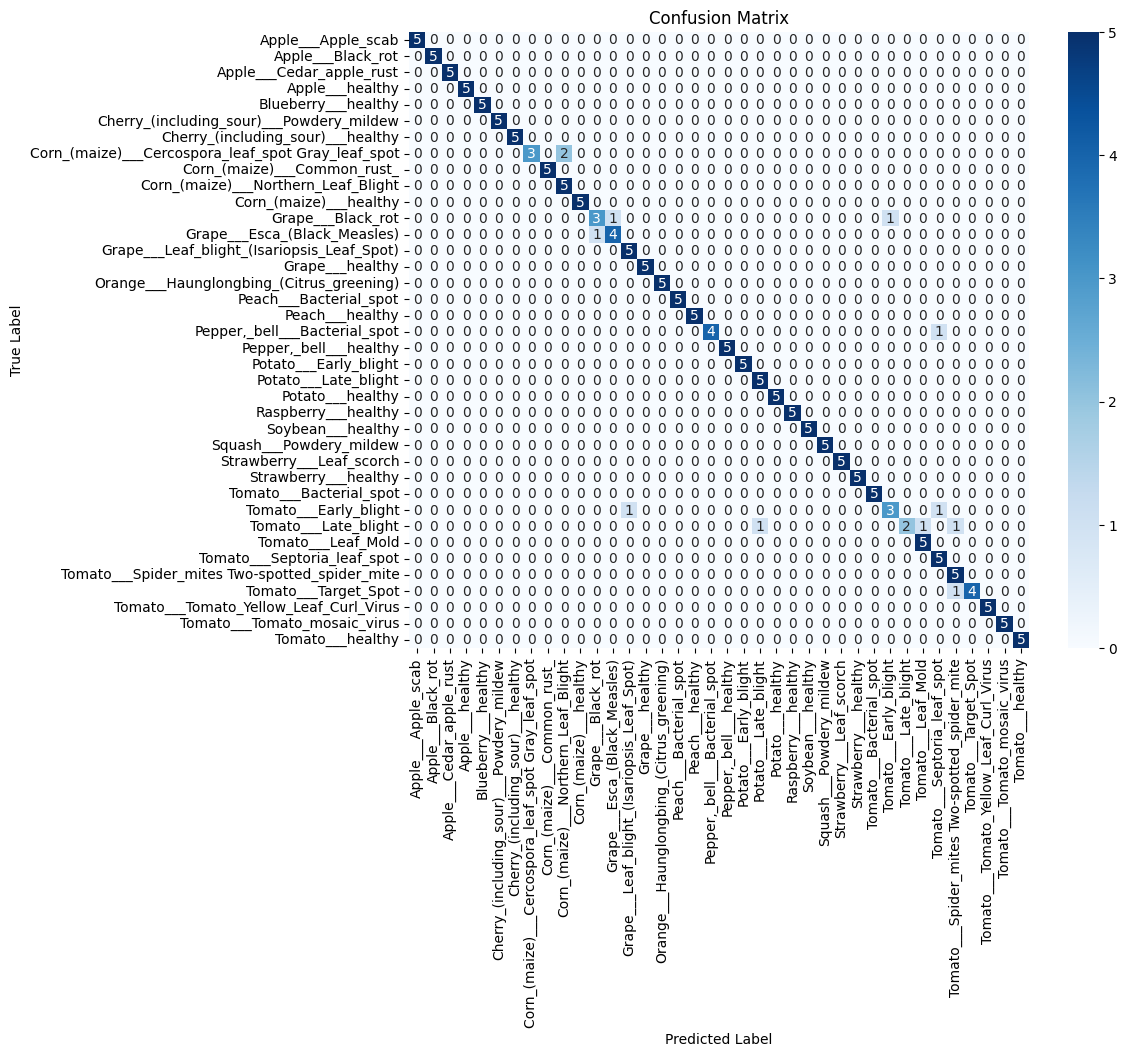


Displaying 27 selected images with their predictions and probability distributions:



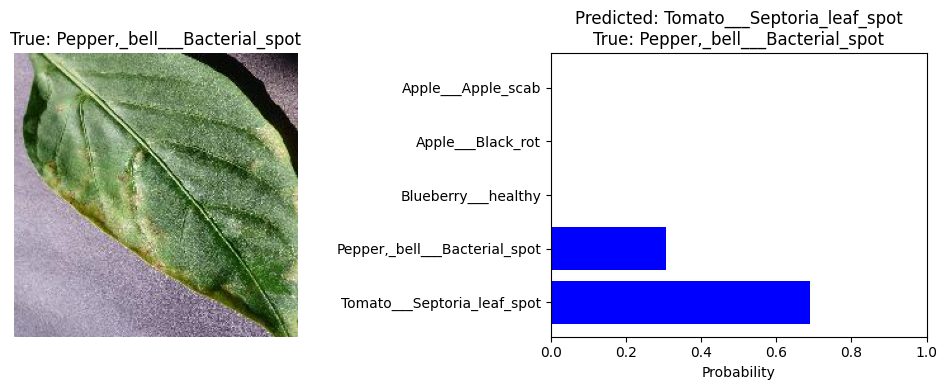

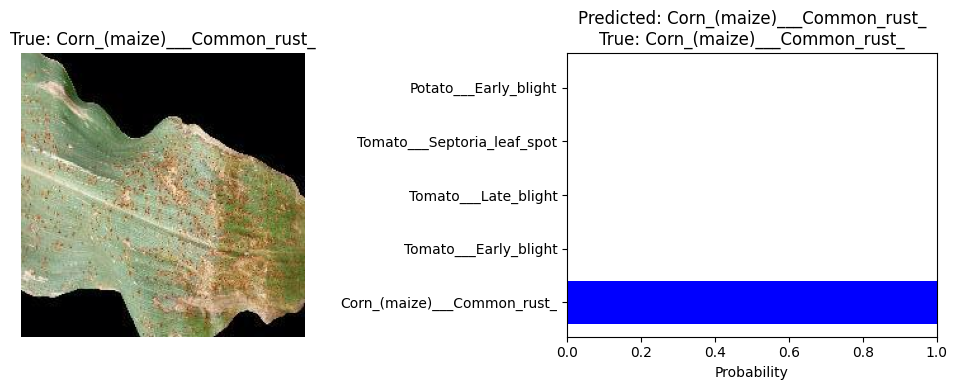

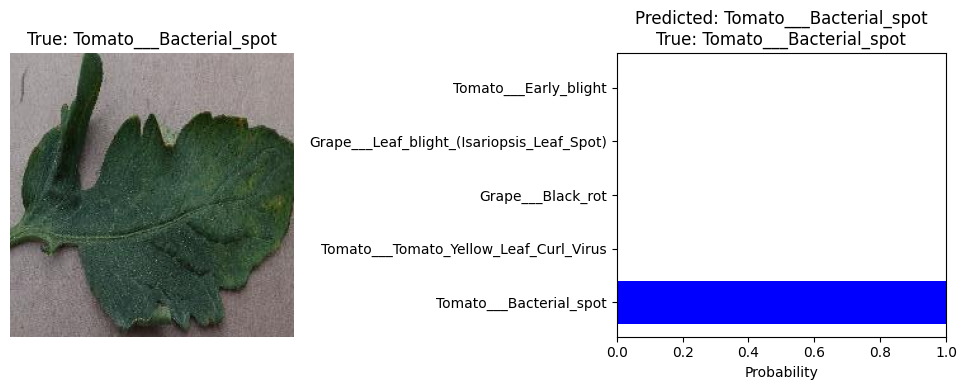

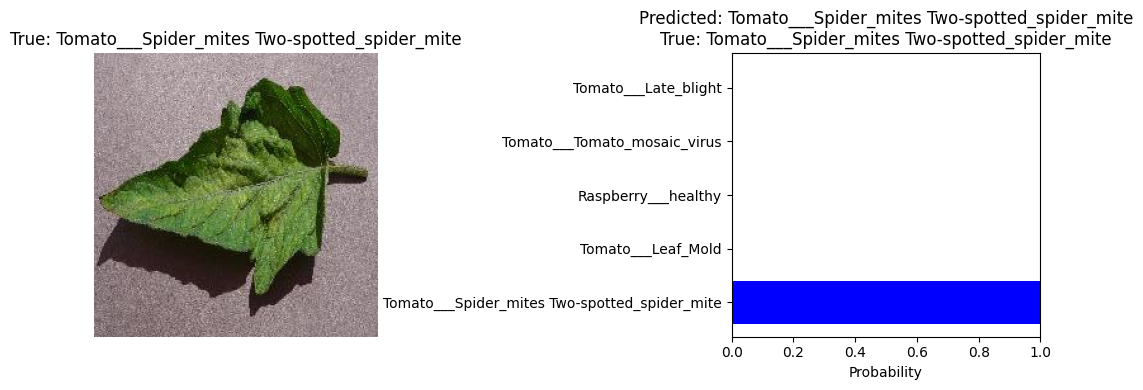

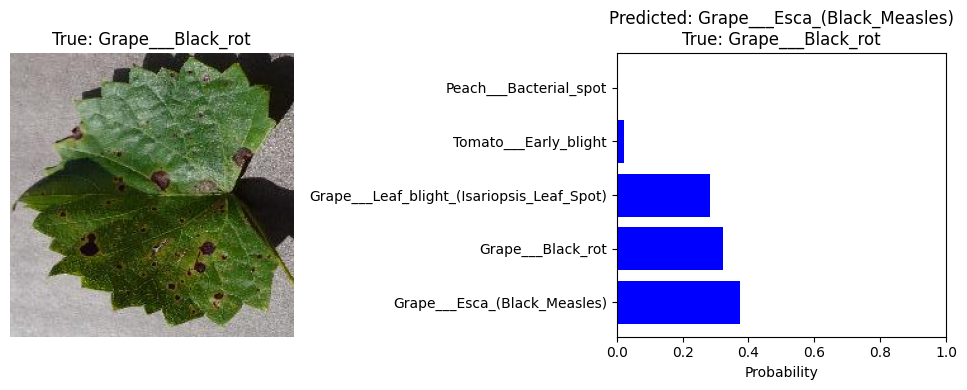

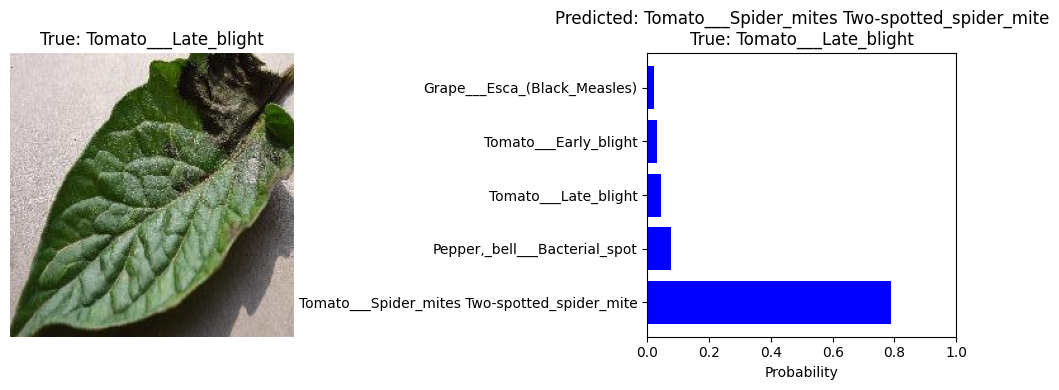

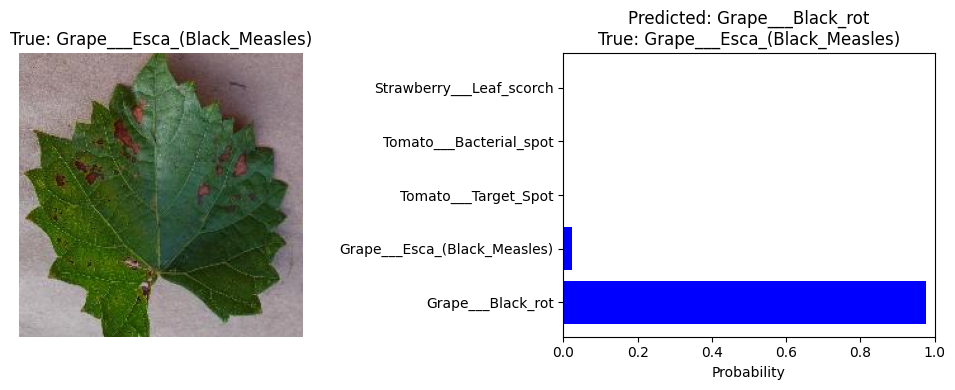

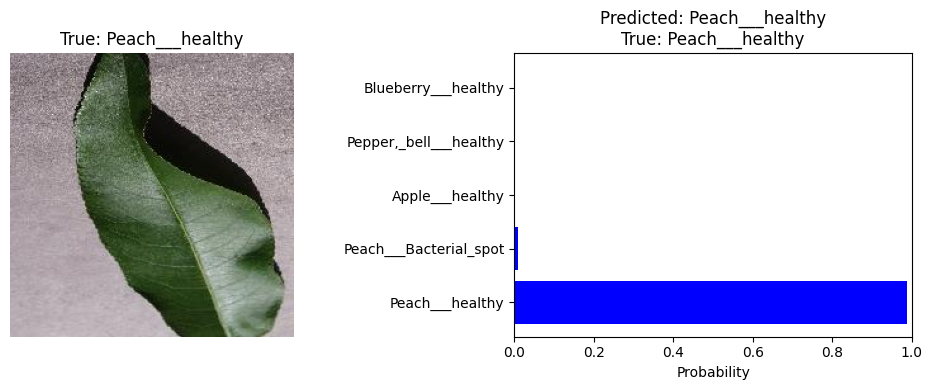

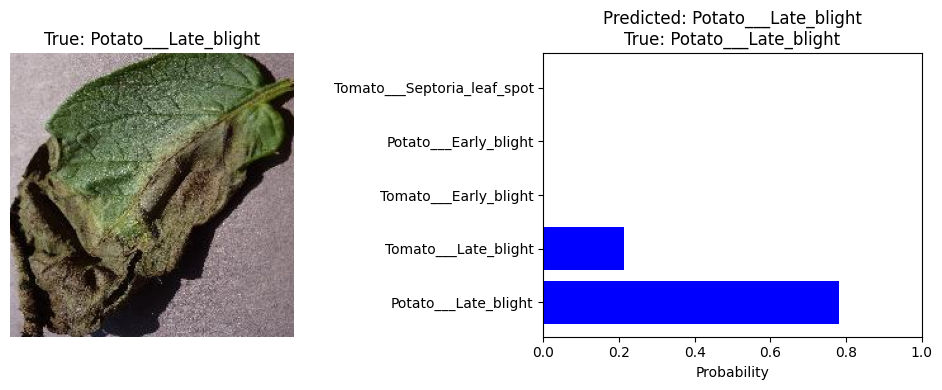

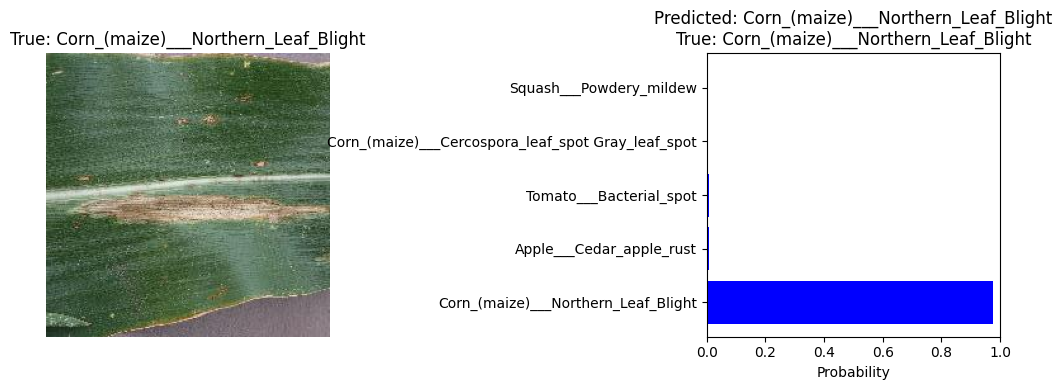

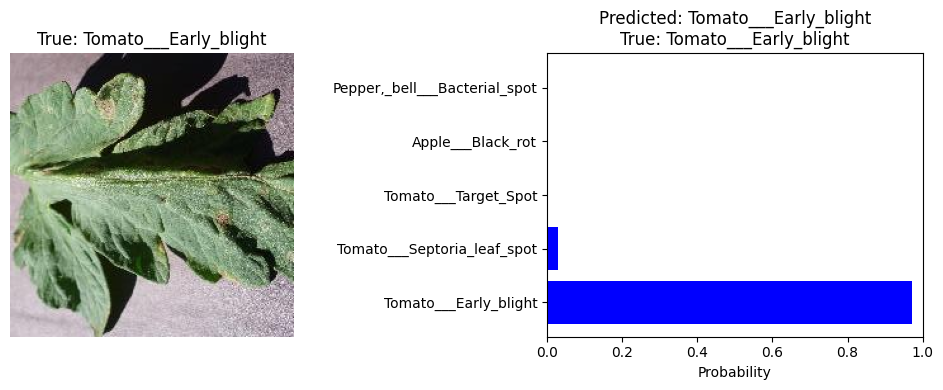

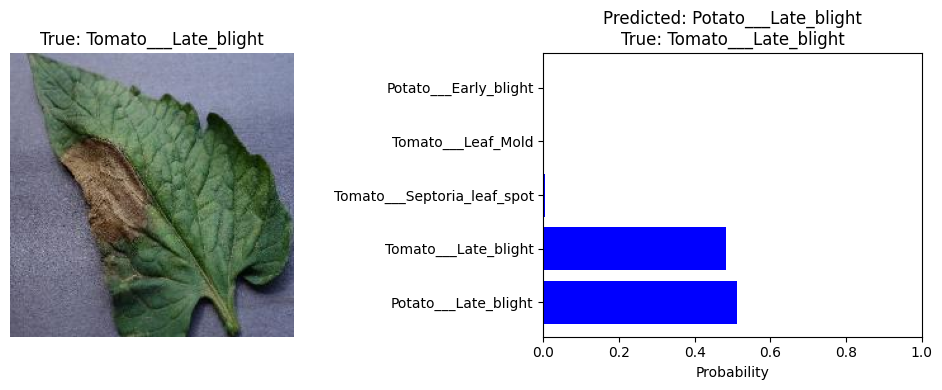

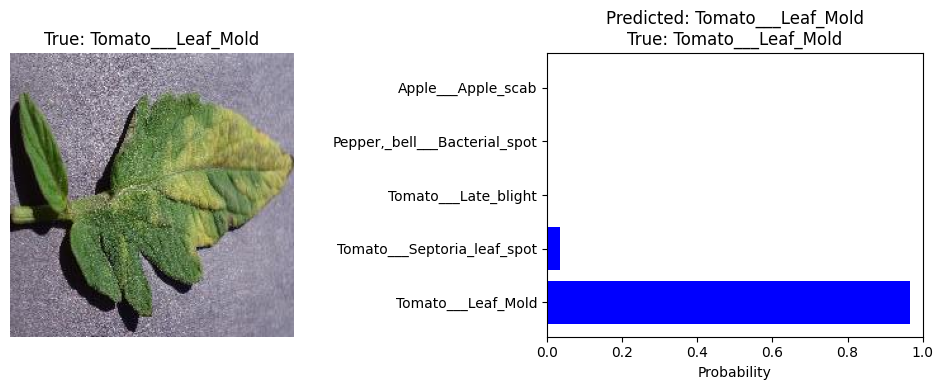

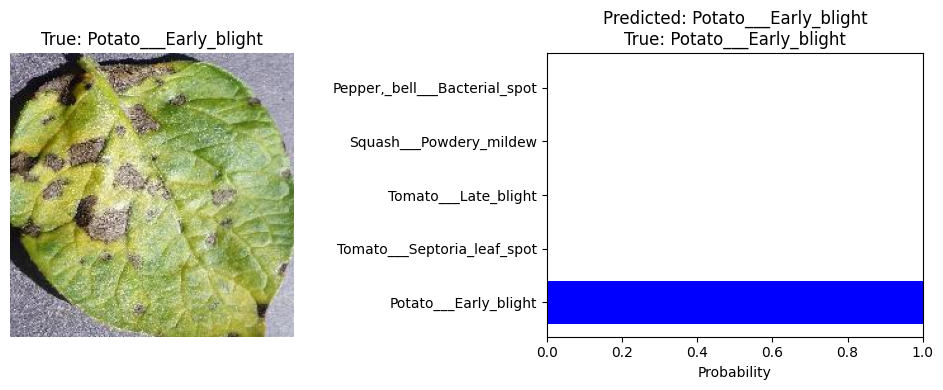

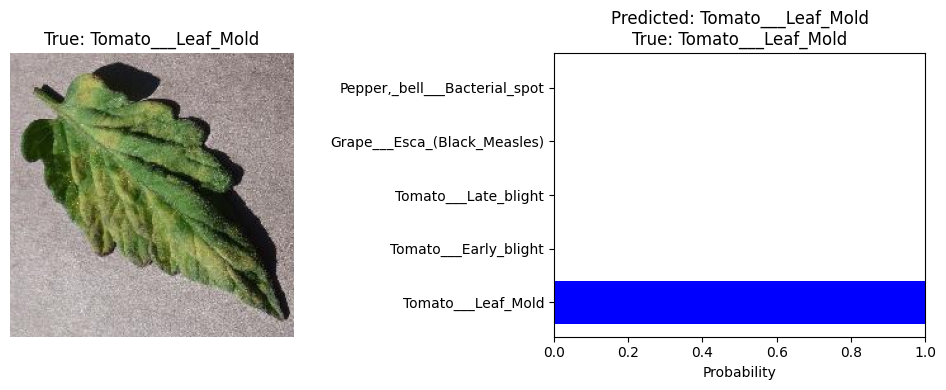

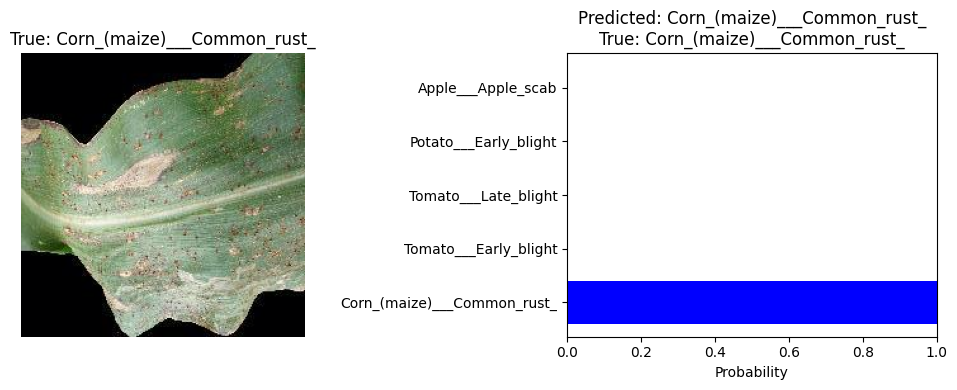

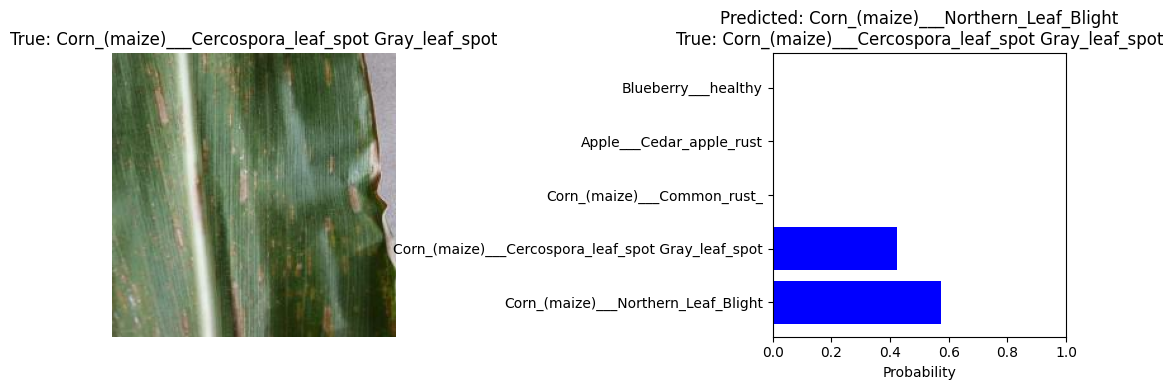

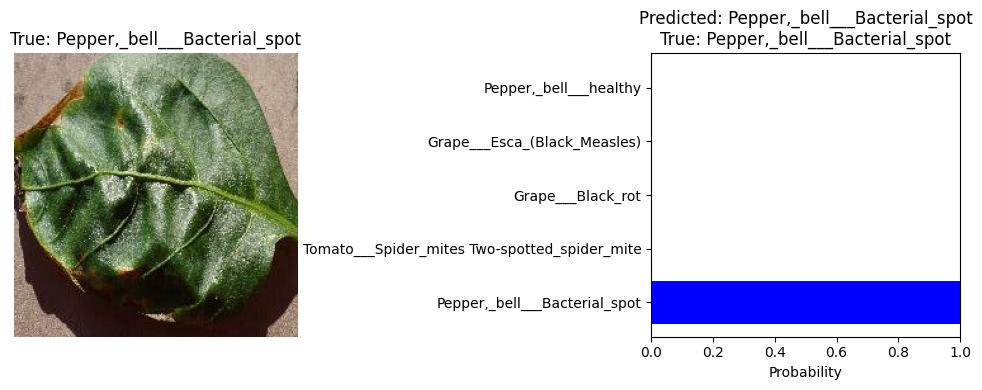

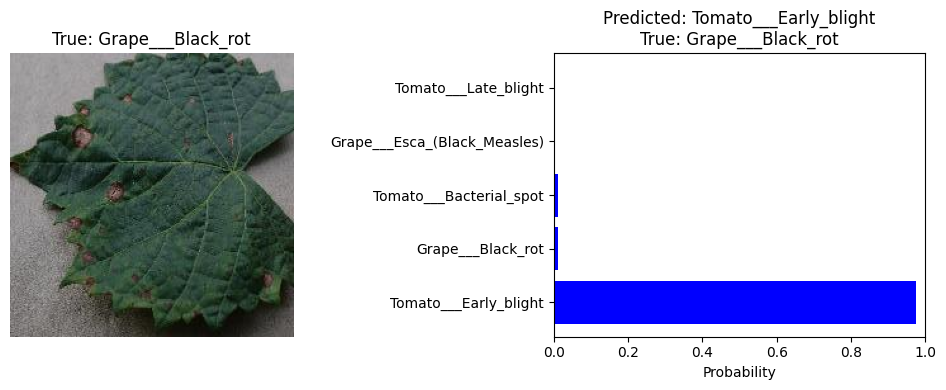

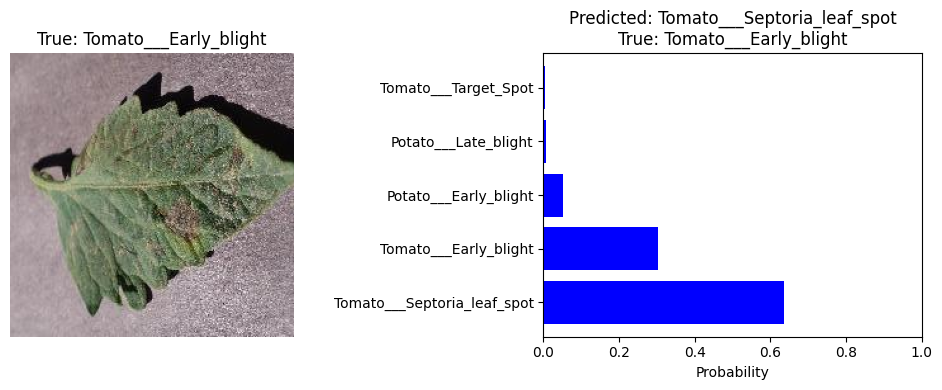

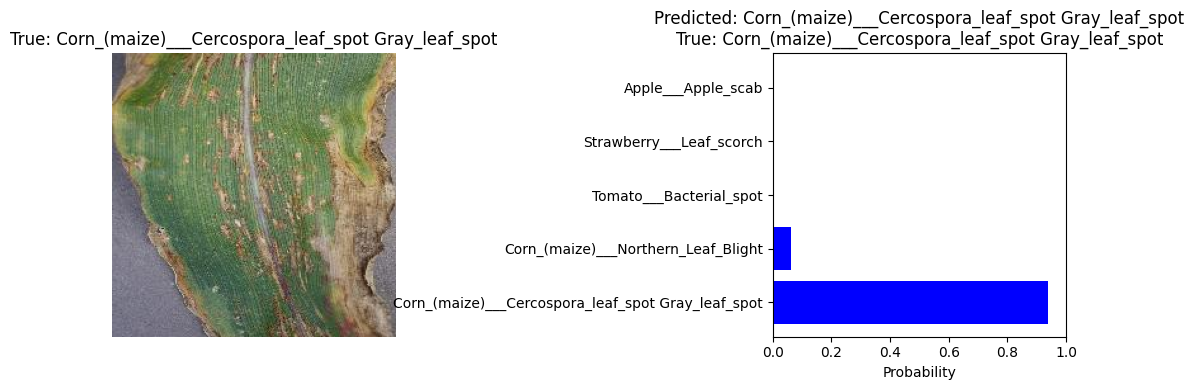

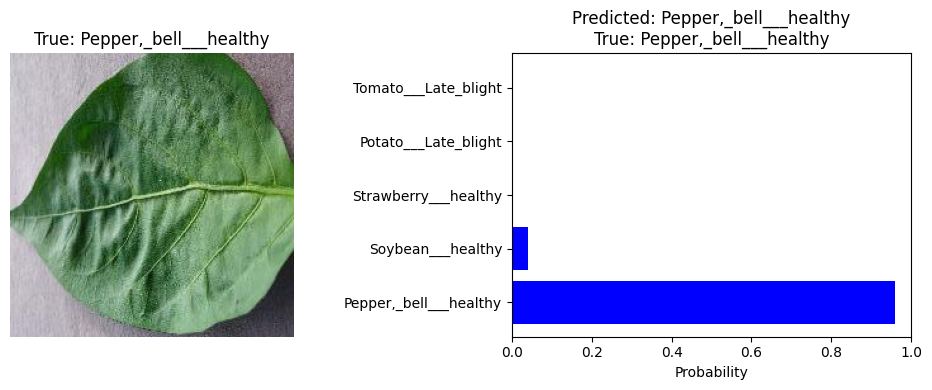

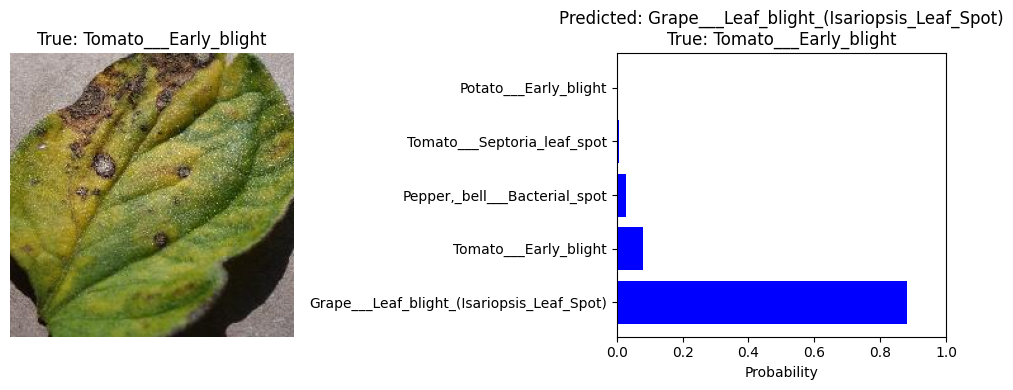

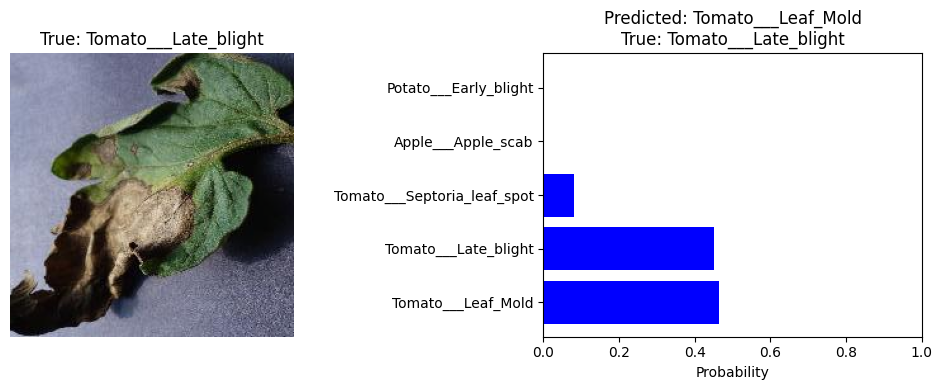

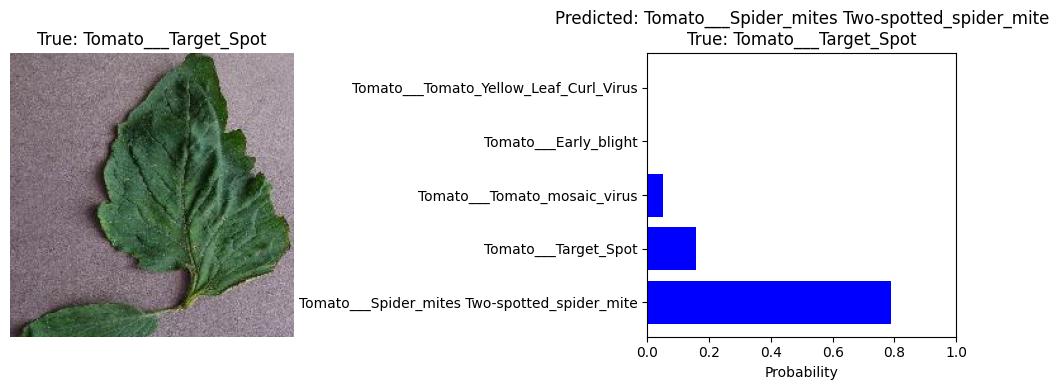

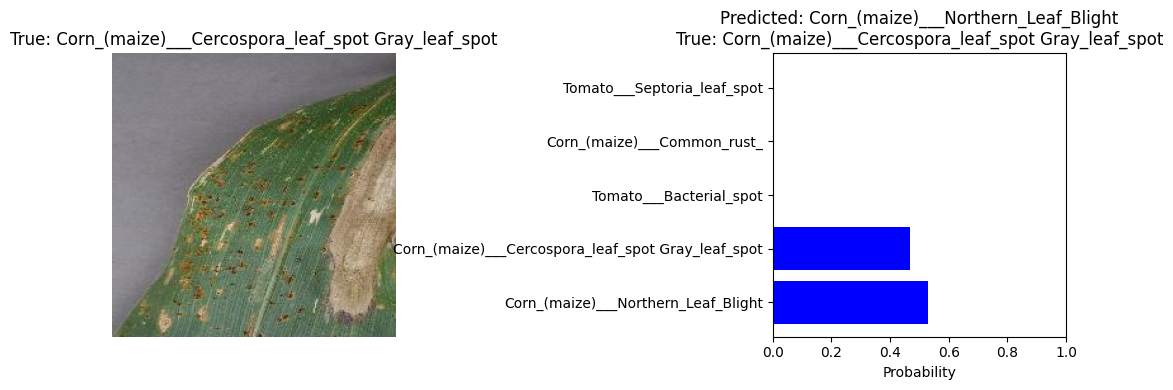

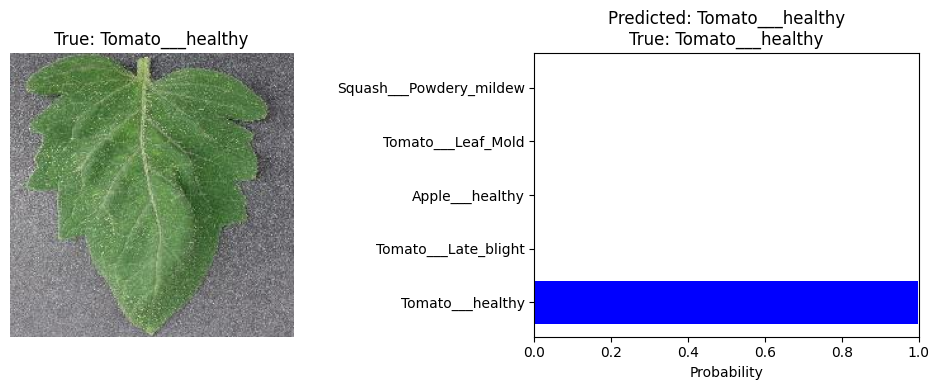

In [35]:

# Step 4: Run the evaluation and display random visualizations
evaluate_model_with_visualizations(model, transformed_dataloader, transformed_dataset.classes)